## 异常检测——基于相似度的方法
本节对教程上的内容进行了理解，结合一些参考资料，理解了大概。参考链接如下。  
结合LOF的代码进行了分析（由于本人是小白，所以主要对代码的一些函数进行了解释，并打印了显示效果）。
1、LOF（sklearn)代码分析
2、练习-学习使用PyOD库生成toy example并调用LOF算法
参考链接：
https://zhuanlan.zhihu.com/p/37753692

## 1、LOF代码实现 


In [14]:
# 构造两个数据点集群
X_inliers1 = 0.2 * np.random.randn(100, 2)
X_inliers2 = 0.5 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers1 + 2, X_inliers2 - 2]

# 构造一些离群的点
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# 拼成训练集
X = np.r_[X_inliers, X_outliers]

np.r_[X_inliers1 + 2, X_inliers2 - 2]这句话将两个随机生成的点集合的距离拉大。训练集是一个[220,2]的数组，异常点是最后20个点。


In [ ]:
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
# 打标签，群内点构造离群值为1，离群点构造离群值为-1
ground_truth[-n_outliers:] = -1
plt.title('构造数据集 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')


np.ones(len(X), dtype=int)，构建一个全1的数组[220，1]  
ground_truth[-n_outliers:] = -1，将后20个值置为-1（即异常点-1，正常点1）。  ground_truth是训练集中的点的标签。
下面画出训练集的散点图，可以看出个别异常点和正常点融合在一起。这是因为我们是用代码随机生成的异常点，可能有一些随机点会散落在集群内部，而一些集群点由于正态分布的特性，会与其余点的距离相对远一些，造成个别数据点的标注不准确。

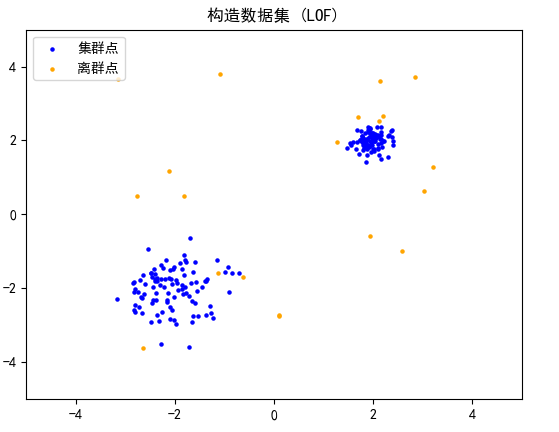

In [ ]:
# 训练模型（找出每个数据的实际离群值）
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# 对单个数据集进行无监督检测时，以1和-1分别表示非离群点与离群点
y_pred = clf.fit_predict(X)

# 找出构造离群值与实际离群值不同的点
n_errors = y_pred != ground_truth
X_pred = np.c_[X,n_errors]

X_scores = clf.negative_outlier_factor_
# 实际离群值有正有负，转化为正数并保留其差异性（不是直接取绝对值）
X_scores_nor = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
X_pred = np.c_[X_pred,X_scores_nor]
X_pred = pd.DataFrame(X_pred,columns=['x','y','pred','scores'])

使用LocalOutlierFactor库对构造数据集进行训练，得到训练的标签和训练分数（局部离群值）。  
n_errors = y_pred != ground_truth，将预测结果和我们的标签集合进行比较  
X_pred = np.c_[X,n_errors]，将比较结果作为预测结果合并


将局部离群值标准化，并且合并,最终得到DataFrame:

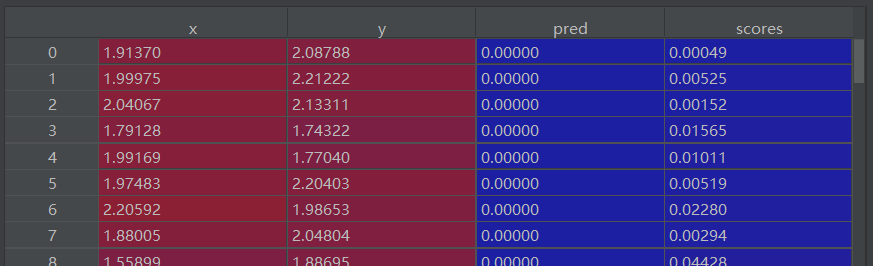

In [ ]:
X_pred_same = X_pred[X_pred['pred'] == False]
X_pred_different = X_pred[X_pred['pred'] == True]

plt.title('局部离群因子检测 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

# 以标准化之后的局部离群值为半径画圆，以圆的大小直观表示出每个数据点的离群程度
plt.scatter(X_pred_same.values[:,0], X_pred_same.values[:, 1],
            s=1000 * X_pred_same.values[:, 3], edgecolors='c',
            facecolors='none', label='标签一致')
plt.scatter(X_pred_different.values[:, 0], X_pred_different.values[:, 1],
            s=1000 * X_pred_different.values[:, 3], edgecolors='violet',
            facecolors='none', label='标签不同')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

    可以看出，模型成功区分出了大部分的离群点，一些因为随机原因散落在集群内部的“离群点”也被识别为集群内部的点，但是一些与集群略为分散的“集群点”则被识别为离群点。
  同时可以看出，模型对于不同密度的集群有着较好的区分度，对于低密度集群与高密度集群使用了不同的密度阈值来区分是否离群点。
  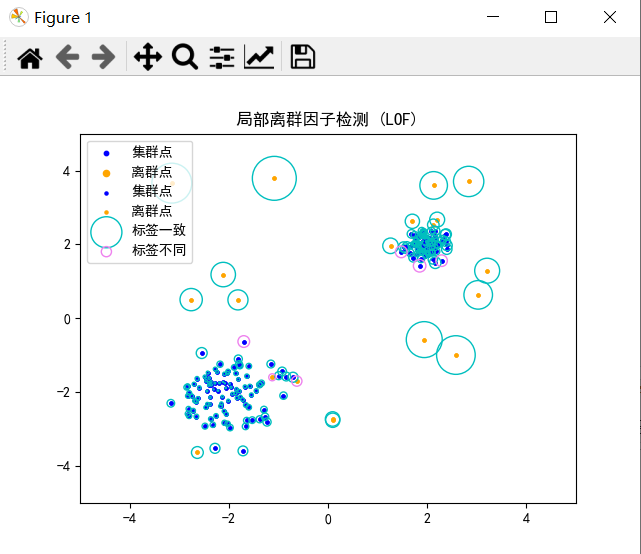

## 2、练习：用Pyod库实现LOF  
改用Pyod库中的LOF模型，修改上面的代码：  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import evaluate_print
from pyod.models.lof import LOF

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(61)

# 构造两个数据点集群
X_inliers1 = 0.2 * np.random.randn(100, 2)
X_inliers2 = 0.5 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers1 + 2, X_inliers2 - 2]

# 构造一些离群的点
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# 拼成训练集
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.zeros(len(X), dtype=int)
# 打标签，群内点构造离群值为0，离群点构造离群值为1
ground_truth[-n_outliers:] = 1
plt.title('构造数据集 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

# 训练模型（找出每个数据的实际离群值）
#clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
clf_name = 'LOF'
clf = LOF()

# 对单个数据集进行无监督检测时，以1和-1分别表示非离群点与离群点
#_pred = clf.fit_predict(X)
clf.fit(X)
y_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
X_scores = clf.decision_scores_  # raw outlier scores
#X_scores = clf.negative_outlier_factor_

# 找出构造离群值与实际离群值不同的点
n_errors = y_pred != ground_truth
X_pred = np.c_[X,n_errors]


# 实际离群值有正有负，转化为正数并保留其差异性（不是直接取绝对值）
X_scores_nor = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
X_pred = np.c_[X_pred,X_scores_nor]
X_pred = pd.DataFrame(X_pred,columns=['x','y','pred','scores'])

X_pred_same = X_pred[X_pred['pred'] == False]
X_pred_different = X_pred[X_pred['pred'] == True]

plt.title('局部离群因子检测 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

# 以标准化之后的局部离群值为半径画圆，以圆的大小直观表示出每个数据点的离群程度
plt.scatter(X_pred_same.values[:,0], X_pred_same.values[:, 1],
            s=1000 * X_pred_same.values[:, 3], edgecolors='c',
            facecolors='none', label='标签一致')
plt.scatter(X_pred_different.values[:, 0], X_pred_different.values[:, 1],
            s=1000 * X_pred_different.values[:, 3], edgecolors='violet',
            facecolors='none', label='标签不同')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

改用Pyod库中的LOF模型，检测结果如下：LOF ROC:1.0, precision @ rank n:1.0
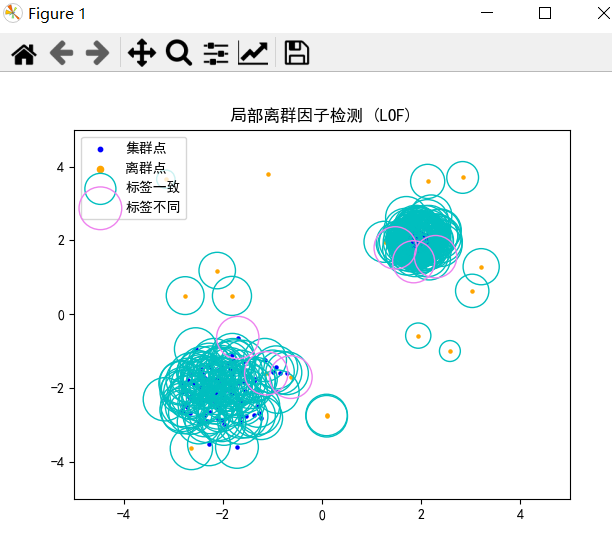
检测结果和上个例子差不多（绝大部分与标签相符）。显示图形显得很乱，是因为图中以局部离群值作为半径画圆， 反应点的离群程度。因为sklearn模型生成的离群值都是负值，而pyod模型生成的离群值都是正值。这样，用原有的标准化代码，生成的离群值是异常点反而更小。标准化代码修改为X_scores_nor = (X_scores - X_scores.min()) / (X_scores.max() - X_scores.min())，检测结果如下：
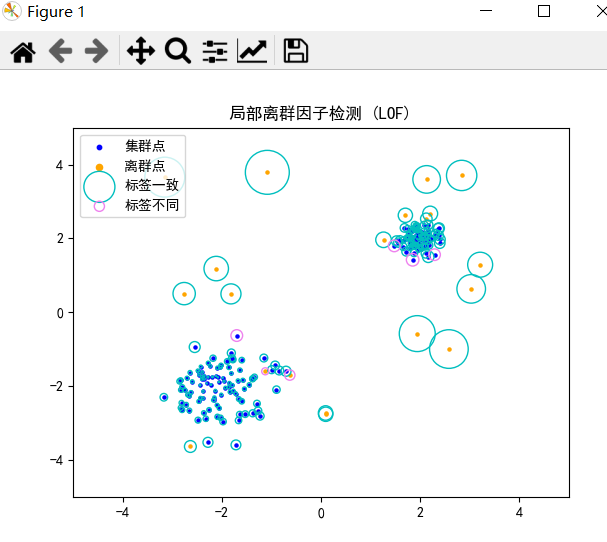

下面是找到的一些有价值的问题和解答  
1、多大的 LOF 才是离群值？  
LOF 计算结果对于多大的值定义为离群值没有明确的规定。在一个平稳数据集中，可能 1.1 已经是一个异常值，而在另一个具有强烈数据波动的数据集中，即使 LOF 值为 2 可能仍是一个正常值。由于方法的局限性，数据集中的异常值界定可能存在差异，笔者认为可以使用统计分布方法作为参考，再结合数据情况最终确定阈值。  
2、数据维度过大，还能使用 LOF 算法吗？  
数据维度过大一方面会增大量纲的影响，另一方面增大计算难度。此时直接使用距离度量的表达形式不合理，并有人为放大较为分散数据影响的风险。一种处理方式是采用马氏距离作为距离度量的方式（去量纲化）。另一种处理方式，参考随机森林的决策思想，可以考虑在多个维度投影上使用 LOF 并将结果结合起来，以提高高维数据的检测质量。
3、如何提高识别精度  
合理增大K值能显著提高识别精度。但 K 值的增加会带来不必要的计算、影响算法执行效率，也正因此本文所用的 K值都取较小。合理选取K值 与阈值将是 LOF 成功与否的关键。